# Meta-Training SNNs using MAML

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from collections import OrderedDict

from yingyang.dataset import YinYangDataset

import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import argparse
from torchviz import make_dot
from tqdm.notebook import tqdm, trange

In [2]:
%load_ext autoreload
%autoreload 2

## Data and Config

In [3]:
from eventprop.config import get_flat_dict_from_nested

In [4]:
data_config = {
    "seed": 42,
    "dataset": "ying_yang",
    "deterministic": True,
    "meta_batch_size": 10,
    "encoding": "latency",
    "T": 50,
    "dt": 1e-3,
    "t_min": 0,
    "t_max": 2,
    "data_folder": "../../../data/",
    "n_samples_per_task": 100,  # adaptation steps
    "n_tasks_per_split": 64,  # number of rotations
    "dataset_size": 1000,  # testing size
}
data_args = argparse.Namespace(**data_config)

In [5]:
torch.manual_seed(data_config["seed"])
np.random.seed(data_config["seed"])
random.seed(data_config["seed"])

data_config["dataset"] = data_config["dataset"]
if data_config["deterministic"]:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
torch.cuda.is_available()

False

## Rotation Ying Yang data for Meta Learning

In [7]:
from yingyang.meta_dataset import YingYangMetaDataset
from torchmeta.utils.data import BatchMetaDataLoader
from eventprop.training import encode_data
from torchmeta.transforms import ClassSplitter

In [8]:
encode_tranform = lambda s: (encode_data(s[0], data_args), s[1])

dataset_split = lambda d: ClassSplitter(
    d,
    num_train_per_class=data_config["dataset_size"],
    num_test_per_class=data_config["dataset_size"],
    shuffle=False,
)

meta_train_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_train=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)
meta_val_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_val=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)
meta_test_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_test=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)

meta_train_dataloader = BatchMetaDataLoader(
    meta_train_dataset,
    data_config["meta_batch_size"],
    shuffle=True,
    num_workers=0,
)

meta_val_dataloader = BatchMetaDataLoader(
    meta_val_dataset,
    data_config["meta_batch_size"],
    shuffle=False,
    num_workers=0,
)

meta_test_dataloader = BatchMetaDataLoader(
    meta_test_dataset,
    data_config["meta_batch_size"],
    shuffle=False,
    num_workers=0,
)

In [9]:
training_batch = next(iter(meta_train_dataloader))
testing_batch = next(iter(meta_test_dataloader))

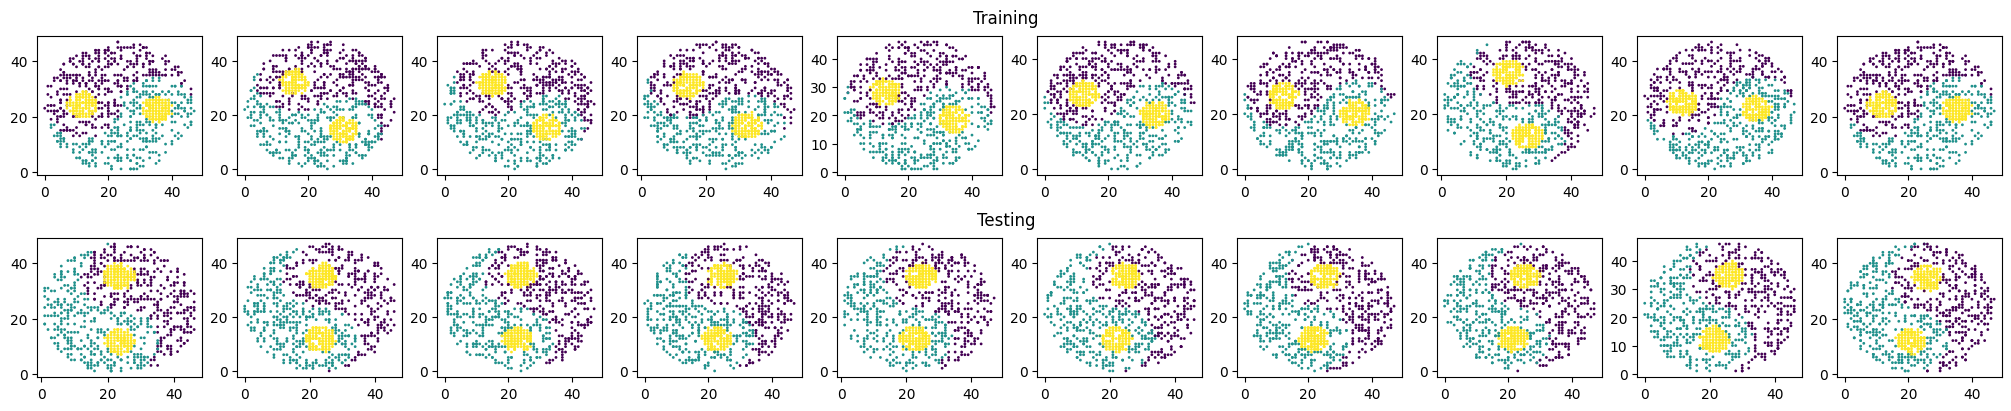

In [10]:
fig = plt.figure(figsize=(2 * data_config["meta_batch_size"], 4), constrained_layout=True)
subfigs = fig.subfigures(2, 1)

for batch, subfig in zip([training_batch, testing_batch], subfigs):
    axs = subfig.subplots(1, data_config["meta_batch_size"])
    for i, (x, y) in enumerate(zip(*batch["train"])):
        try:
            ax = axs[i]
        except TypeError:
            ax = axs
        ax.scatter(
            x.argmax(1).squeeze()[:, 0], x.argmax(1).squeeze()[:, 1], c=y, cmap="viridis", s=1
        )
    subfig.suptitle("Training" if batch is training_batch else "Testing")

## Models

In [11]:
from eventprop.models import SNN, SpikeCELoss, FirstSpikeTime

In [12]:
model_config = {
    "model_type": "eventprop",
    "snn": {
        "T": data_config["T"],
        "dt": data_config["dt"],
        "tau_m": 20e-3,
        "tau_s": 5e-3,
    },
    "weights": {
        "init_mode": "kaiming_both",
        "scale_0_mu": 5,
        "scale_0_sigma": 3.5,
        "scale_1_mu": 5,
        "scale_1_sigma": 0.5,
        "n_hid": 120,
        "resolve_silent": False,
        "dropout": 0.0,
    },
    # "device": (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")),
    "device": torch.device("cpu"),
}

n_ins = {"mnist": 784, "ying_yang": 5 if data_config["encoding"] == "latency" else 4}
n_outs = {"mnist": 10, "ying_yang": 3}

In [13]:
training_config = {
    "num_epochs": 20,
    "loss": "ce_temporal",
    "alpha": 3e-3,
    "xi": 0.5,
    "beta": 6.4,
    "n_tests": 3,
    "exclude_equal": False,
    "do_train": True,
    "do_test": False,
}

## Inner Loop Optim
optim_config = {
    "lr": 5e-3,
    "weight_decay": 0.0,
    "optimizer": "adam",
    "gamma": 0.95,
}

maml_config = {
    "num_shots": 100,
    "num_shots_test": 1000,
    "first_order": True,
    "meta-lr": 1e-2,
    "inner-lr": 1e-2,
    "learn_step_size": False,
    "meta-gamma": 0.95,
}

default_config = {
    "data": data_config,
    "model": model_config,
    "training": training_config,
    "optim": optim_config,
    "maml": maml_config,
}
config = get_flat_dict_from_nested(default_config)
args = argparse.Namespace(**config)

In [14]:
dims = [n_ins[config["dataset"]]]
if config["n_hid"] is not None and isinstance(config["n_hid"], list):
    dims.extend(config["n_hid"])
elif isinstance(config["n_hid"], int):
    dims.append(config["n_hid"])
dims.append(n_outs[config["dataset"]])

model = SNN(dims, **config).to(config["device"])
init_params = OrderedDict(model.meta_named_parameters()).copy()
first_spk_fn = FirstSpikeTime.apply

SNN SCALE :  [[5, 3.5], [5, 0.5]]


## MAML

In [18]:
from copy import deepcopy

In [25]:
class MAML(object):

    def __init__(self, model, default_config) -> None:

        self.model = model
        self.default_config = default_config
        self.flat_config = get_flat_dict_from_nested(default_config)
        self.args = argparse.Namespace(**self.flat_config)

        self.inner_optimizer = torch.optim.Adam(
            model.parameters(), lr=1e-3, weight_decay=config["weight_decay"]
        )
        self.inner_loss_fn = SpikeCELoss(
            alpha=self.flat_config["alpha"],
            xi=self.flat_config["xi"],
            beta=self.flat_config["beta"],
        )
        self.first_spk_fn = FirstSpikeTime.apply

    def adapt(self, meta_sample, use_tqdm=False):

        inputs, targets = meta_sample
        inputs, targets = inputs.to(self.args.device), targets.to(self.args.device)
        params = deepcopy(OrderedDict(self.model.meta_named_parameters()))
        optimizer = torch.optim.Adam(
            params.values(), lr=self.flat_config["inner-lr"], weight_decay=config["weight_decay"]
        )

        # batch one
        for input, target, _ in zip(
            inputs,
            targets,
            trange(self.flat_config["num_shots"]) if use_tqdm else range(self.flat_config["num_shots"]),
        ):
            out_spikes, recordings = model(input, params=params)
            loss = self.inner_loss_fn(out_spikes, target)[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        return params

    def inner_test(self, meta_sample, params=None):

        inputs, targets = meta_sample
        inputs = inputs.transpose(0, 1).to(self.args.device).squeeze()
        out_spikes, recordings = model(inputs, params=params)
        first_spikes = self.first_spk_fn(out_spikes)
        acc = (first_spikes.argmin(-1) == targets).float().mean()
        loss = self.inner_loss_fn(out_spikes, targets)[0]
        return acc, loss, recordings

    def get_outer_loss(self, meta_batch, use_tqdm=False):

        meta_losses = {"pre": [], "post": []}
        meta_accs = {"pre": [], "post": []}

        adapted_params = {}
        n_tasks = len(meta_batch["train"][0])
        if use_tqdm:
            pbar = trange(n_tasks, desc="Task: ")
        else:
            pbar = range(n_tasks)

        for task, (*train_meta_sample, _) in enumerate(
            zip(*meta_batch["train"], pbar)
        ):
            test_meta_sample = [s[task] for s in meta_batch["test"]]
            pre_acc, pre_loss, _ = self.inner_test(test_meta_sample)
            pre_acc = pre_acc.detach().cpu().numpy()
            meta_accs["pre"].append(pre_acc)
            meta_losses["pre"].append(pre_loss)

            new_params = self.adapt(train_meta_sample)
            adapted_params[task] = new_params

            post_acc, post_loss, _ = self.inner_test(test_meta_sample, params=new_params)
            post_acc = post_acc.detach().cpu().numpy()
            meta_accs["post"].append(post_acc)
            meta_losses["post"].append(post_loss)

            if use_tqdm:
                pbar.set_description(f"Task: {task}, Pre: {pre_acc:.2f}, Post: {post_acc:.2f}")

        return {"meta_accs": meta_accs, "meta_losses": meta_losses, "params": adapted_params}

In [26]:
maml_trainer = MAML(model, default_config)

In [17]:
raise KeyboardInterrupt

KeyboardInterrupt: 

### Making sure we can overfit on one subtask

In [27]:
inputs, targets = training_batch["test"]
inputs = inputs[0].to(config["device"])
targets = targets[0].to(config["device"])
    
acc, loss, recs = maml_trainer.inner_test((inputs, targets))
print(f"Pre Adaptation Accuracy: {acc}")

Pre Adaptation Accuracy: 0.3330000042915344


In [28]:
inputs, targets = training_batch["train"]
inputs = inputs[0]
targets = targets[0].to(config["device"])
new_params = maml_trainer.adapt((inputs, targets), use_tqdm=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
inputs, targets = training_batch["test"]
inputs = inputs[0].to(config["device"])
targets = targets[0].to(config["device"])
    
acc, loss, recs = maml_trainer.inner_test((inputs, targets), new_params)
print(f"Post Adaptation Accuracy: {acc}")

Post Adaptation Accuracy: 0.6549999713897705


## Outer Loss

In [30]:
results = maml_trainer.get_outer_loss(training_batch, use_tqdm=True)

Task:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
results